In [1]:
import cv2
import numpy as np # this module is useful to work with numerical arrays
import torch
import torchvision
from torchvision import transforms
from torch import nn
import matplotlib.pyplot as plt
import time

transform = transforms.ToTensor()

width = 640
height = 360

entries = []
cap = cv2.VideoCapture('C:\\Users\\trett\Documents\GitHub\ThirdYearProject\pytorch\input_video_rgb.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
if not cap.isOpened():
    print("Error: could not open video file")
ret, first_frame = cap.read()
if not ret:
    print("Error: could not read first frame")
    exit()
while cap.isOpened():
    ret, middle_frame = cap.read()
    if not ret:
        break
    ret, last_frame = cap.read()
    if not ret:
        break
    # Process the batch of 3 frames here
    # batch_of_frames = [transform(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)),
    #                    transform(cv2.cvtColor(middle_frame, cv2.COLOR_BGR2RGB)),
    #                    transform(cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB))]
    batch_of_frames = [transform(first_frame), transform(middle_frame), transform(last_frame)]
    entries.append(batch_of_frames)
    # cv2.imshow('batch_of_frames', first_frame)
    # if cv2.waitKey(25) & 0xFF == ord('q'):
    #     break
    # Update the previous frames
    first_frame = last_frame
cap.release()
# cv2.destroyAllWindows()

# class MyVideoDataset(Dataset):
#
#     entries = []
#     len_entries = 0
#
#     def __int__(self):
#         transform = transforms.Compose([
#             transforms.ToPILImage(),
#             transforms.ToTensor()
#         ])
#         cap = cv2.VideoCapture('C:\\Users\\trett\Documents\GitHub\ThirdYearProject\pytorch\input_video_color.mp4')
#         if not cap.isOpened():
#             print("Error: could not open video file")
#         ret, first_frame = cap.read()
#         if not ret:
#             print("Error: could not read first frame")
#             exit()
#         while cap.isOpened():
#             ret, middle_frame = cap.read()
#             if not ret:
#                 break
#             ret, last_frame = cap.read()
#             if not ret:
#                 break
#             f1 = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
#             f2 = cv2.cvtColor(middle_frame, cv2.COLOR_BGR2RGB)
#             f3 = cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB)
#
#             batch_of_frames = [f1, f2, f3]
#             self.entries.append(transform(f1))
#             self.len_entries = self.len_entries + 1
#
#             # Update the previous frames
#             first_frame = last_frame
#         cap.release()
#
#     def __len__(self):
#         return self.len_entries
#
#     def __getitem__(self, idx):
#         return self.entries[idx]

# batch_size = 10
# train_dataset = MyVideoDataset()
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
#
# for batch in train_loader:
#     print(len(batch))
#     break



In [2]:
class Autoencoder(nn.Module):

    def __init__(self):
        super().__init__()

        self.lefthand_encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )

        self.righthand_encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True)
        )


    def forward(self, left, right):
        left = self.lefthand_encoder(left)
        right = self.lefthand_encoder(right)
        encoded = torch.cat((left, right), 0)
        x = self.decoder(encoded)
        return x


In [3]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.0001

### Set the random seed for reproducible results
# torch.manual_seed(0)

### Initialize the two networks
d = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
autoencoder = Autoencoder()
params_to_optimize = [
    {'params': autoencoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-08)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
autoencoder = autoencoder.to(device)


Selected device: cuda


In [4]:
autoencoder.train()

epochs = 10

for i in range(epochs):
    train_loss = []
    start = time.time()
# Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for batch in entries:  # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        first_frame = batch[0].to(device)
        middle_frame = batch[1].to(device)
        last_frame = batch[2].to(device)

        # Encode data
        res_frame = autoencoder(first_frame, last_frame)
        # image_np = torchvision.transforms.functional.invert(res_frame.cpu().data).numpy()

        # Display the image using matplotlib

        # Evaluate loss
        loss = loss_fn(res_frame, middle_frame)
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        # Print batch loss
        # print('\t %d partial train loss (single batch): %f' % (i, loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    print(np.mean(train_loss))
    end = time.time()
    print(end - start)

0.008933225
32.392266511917114
0.0010182227
18.44089674949646
0.0009051805
12.29950737953186
0.00085149705
12.257001399993896
0.0008229616
12.296000719070435
0.0008023746
12.272001504898071
0.0007849682
12.281015396118164
0.0007690976
12.295093774795532
0.0007534439
12.30142593383789
0.00073834695
12.305249452590942


In [2]:
# out = cv2.VideoWriter('out_sidebyside.mp4', fourcc, fps, (width*2, height), isColor=True)
for batch in entries:  # with "_" we just ignore the labels (the second element of the dataloader tuple)
    # Move tensor to the proper device
    first_f = np.transpose(batch[0].numpy(), (1, 2, 0))
    original_f = np.transpose(batch[1].numpy(), (1, 2, 0))

    first_frame = batch[0].to(device)
    middle_frame = batch[1].to(device)
    last_frame = batch[2].to(device)

    # Encode data
    res_frame = autoencoder(first_frame, last_frame)
    # image_np = torchvision.transforms.functional.invert(res_frame.cpu().data).numpy()
    # out.write(first_frame)
    # plt.imshow(np.transpose(image_np, (1, 2, 0)))
    # plt.show()
    middle_f = np.transpose(res_frame.cpu().data.numpy(), (1, 2, 0))
    # out.write(cv2.hconcat([first_f, first_f]))
    # out.write(cv2.hconcat([original_f, middle_f]))
    cv2.imshow('generated frame', cv2.hconcat([original_f, middle_f]))
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    # Evaluate loss
    loss = loss_fn(res_frame, middle_frame)
    # Backward pass
    optim.zero_grad()
    loss.backward()
    optim.step()
    # Print batch loss
    print('\t %d partial train loss (single batch): %f' % (i, loss.data))
    i = i + 1

# out.release()

NameError: name 'entries' is not defined

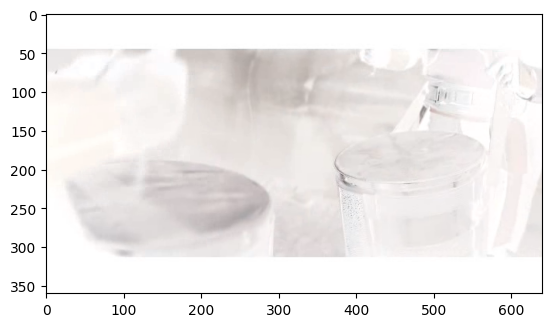

In [15]:
for batch in entries:
    first_frame = entries[100][0]
    middle_frame = entries[100][1]
    last_frame = entries[100][2]
    image_np = torchvision.transforms.functional.invert(middle_frame).numpy()

# Display the image using matplotlib
    plt.imshow(np.transpose(image_np, (1, 2, 0)))
    # plt.imshow(image_np)
    plt.show()
    break